In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader
from tqdm import tqdm 

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
from gdeep.topactivation.svr import SVR
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/home/linuxbrew/.linuxbrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Using GPU!


In [2]:
# Loading the data 
activ = torch.load('/home/meller/Documents/giotto-deep/examples/saves/activ_v5')
model = torch.load('/home/meller/Documents/giotto-deep/examples/saves/model_v5')
activG =torch.load('/home/meller/Documents/giotto-deep/examples/saves/activG_v5')

writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


#cpu = torch.ones(1).device


arch = [28*28,100,50,50,50, 10]
optimizer = torch.optim.SGD
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())


predLabel = torch.zeros(activ.shape[0],activ.shape[1])
for alter in range(activ.shape[0]):
    predLabel[alter] = activ[alter,:,-10:].argmax(dim=1)
    
    
label = torch.zeros(activ[0].shape[0])
k_batch = 0 
for data, target in tqdm(dl_tr):
    label[k_batch*32:(k_batch+1)*32]=target
    k_batch+=1
    if k_batch*32>=activ[0].shape[0]:
        break 

 43%|████████████████▌                      | 799/1875 [00:02<00:02, 372.00it/s]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████| 1563/1563 [00:05<00:00, 277.37it/s]


In [3]:
#from gdeep.data import DataLoaderFromArray -> Useless 


from foolbox import PyTorchModel
from foolbox.attacks import L2FastGradientAttack
atkFGM = L2FastGradientAttack()
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
from gdeep.topactivation.svr import SVR

import os 

def train_new_model(model,X,y,epochs=2,epochs_adv=[]):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=32


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    #model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    atkFGM = L2FastGradientAttack()
    epsilons=[2.0]
    
  
    n_batch = len(X_train)//batch_size
    print("Number of batch per epoch : ",n_batch)


    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(n_batch)):
            data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
            
            
            if epoch in epochs_adv:
                fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=None)
                _,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
                data=clipped_atk[0]

            
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = loss_fn(output, target)
            
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model

In [7]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,bias=False                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 1,bias=False),     
            nn.ReLU(),                      
            nn.MaxPool2d(2)               
        )    
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 16, 3, 1, 1,bias=False),     
            nn.ReLU(),                                     
        )   # fully connected layer, output 10 classes
        self.out = nn.Linear(16 * 7 * 7, 10,bias=False)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output 

In [9]:
model = CNN()
data = activ[0][:,:784].reshape(activ[0].shape[0],1,28,28)
model = train_new_model(model.to(DEVICE),data,label,epochs=3)



Number of batch per epoch :  770


100%|████████████████████████████████████████| 770/770 [00:02<00:00, 310.91it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  87.3051948051948  %
Test Accuracy :  95.9375  %


100%|████████████████████████████████████████| 770/770 [00:02<00:00, 322.92it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  97.23214285714286  %
Test Accuracy :  96.35416666666666  %


100%|████████████████████████████████████████| 770/770 [00:02<00:00, 324.92it/s]

---------------  Epoch :  2  ---------------
Train Accuracy :  97.99918831168831  %
Test Accuracy :  97.60416666666667  %


# Weights analysis

In [10]:
weights = []
for x in model.parameters():
    print(x.shape)
    weights.append(x.detach())

torch.Size([16, 1, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([16, 32, 3, 3])
torch.Size([10, 784])


In [8]:

def star(k1,k2):
    """ Compute the convolution of 2 filters k1 and k2 (7*7) output  
    """
    return torch.nn.functional.conv2d(k1.reshape(1,3,3), k2.reshape(1,1,3,3), bias=None, stride=1, padding=2) 

In [14]:
k1 = weights[0][0][0]
k2 = weights[0][1][0]
print(star(k1,k2).to('cpu').norm())
print(k1.norm()*k2.norm())




tensor(0.6097)
tensor(0.5950, device='cuda:0')


In [12]:
svr = SVR(weights)
cosvr = SVR(weights,method='cosvr')

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 674.71it/s]


In [16]:
svr.plot(sigmaThreshold=1.5)

In [17]:
cosvr.plot(sigmaThreshold=1.5)

In [23]:
idx =2
plt.imshow(svr.U[idx].T@cosvr.V[idx+1])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7840x1 and 16x16)

In [ ]:
svr.arch

In [ ]:
svr.plot(sigmaThreshold=1.5)

In [ ]:
print(svr.V[0].shape)
print(svr.U[0].shape)
print(svr.U[0].norm(dim=0))

In [ ]:
svr.V[-1].norm(dim=0)

In [25]:
svr.arch

[1, 16, 32, 16, 10]

In [30]:
import numpy as np
1.5/np.sqrt(np.array(svr.arch[1:]))

array([0.375     , 0.26516504, 0.375     , 0.47434165])

(array([ 89., 181., 124.,  60.,  21.,  16.,   7.,   9.,   3.,   2.]),
 array([0.04280797, 0.09276854, 0.14272912, 0.19268969, 0.24265027,
        0.29261085, 0.3425714 , 0.392532  , 0.44249257, 0.49245313,
        0.5424137 ], dtype=float32),
 <BarContainer object of 10 artists>)

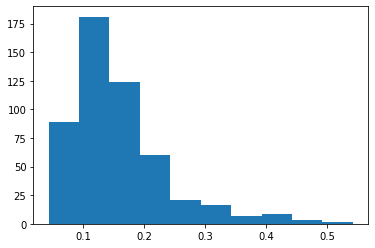

In [26]:
plt.hist(svr.adjacency[1].flatten().numpy())

 # Network evolution

In [200]:

from foolbox import PyTorchModel
from foolbox.attacks import L2FastGradientAttack
from foolbox.attacks import L2ProjectedGradientDescentAttack
atkPGM = L2ProjectedGradientDescentAttack(steps=30)
atkFGM = L2FastGradientAttack()
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
from gdeep.topactivation.svr import SVR

import os 


def train_record_new_model(model,X,y,folder,epochs=3,epochs_adv=[],sigmaThreshold=2,record=False,rate=1):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=32


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    #model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1,weight_decay=1e-5)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    atkFGM = L2FastGradientAttack()
    epsilons=[2.0]
    
    if not os.path.exists('record/'+folder):
        os.mkdir('record/'+folder)
    if record:
        os.system('rm record/'+folder+'/*')
        
    n_batch = len(X_train)//batch_size
    print("Number of batch per epoch : ",n_batch)
    
    
    weights = [A.detach() for A in list(model.parameters())]
    svr = SVR(weights)
    L1 = torch.zeros((n_batch*epochs,len(svr.adjacency )+1 )) 
    Entropy = torch.zeros((n_batch*epochs,len(svr.adjacency )) )
    PM = torch.zeros((n_batch*epochs))
    PM2 = torch.zeros((n_batch*epochs))

    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(n_batch)):
            
            data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
         
            weights = [A.detach() for A in list(model.parameters())]
            name = 'record/'+folder+'/'+str(epoch)+'_'+str(batch_idx)

            svr = SVR(weights)
            if record and batch_idx%rate==0:
                if epoch in epochs_adv:
                    svr.plot_save(name,nodeColor='blueviolet',sigmaThreshold=sigmaThreshold)
                else:
                    svr.plot_save(name,nodeColor='blue',sigmaThreshold=sigmaThreshold)
                    
            L1[epoch*n_batch+batch_idx]= torch.tensor([s.max() for s in svr.S])
            Entropy[epoch*n_batch+batch_idx]= svr.entropy()
            PM[epoch*n_batch+batch_idx] = svr.pathmetric()
            PM2[epoch*n_batch+batch_idx] = svr.pathmetric(svdScale=False)

            
            
            if epoch in epochs_adv:
                fmodel = PyTorchModel(model.eval(), bounds=(0, 1), preprocessing=None)
                _,clipped_atk,_ = atkPGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
                data=clipped_atk[0]

            
            
         
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = loss_fn(output, target)
            
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
        
        for batch_idx in range(len(X_val)//batch_size):
            data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
            fmodel = PyTorchModel(model.eval(), bounds=(0, 1), preprocessing=None)
            _,clipped_atk,_ = atkPGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
            data=clipped_atk[0]
            
            
            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('PGD Robust Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model,L1,Entropy,PM,PM2

In [105]:
model = CNN()
data = activ[0][:,:784]
model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),data,label,'cnn1',record=False,epochs=2,sigmaThreshold=1.5)



NameError: name 'CNN' is not defined

# Training on CIFAR10

In [89]:
# Dataset 
dl = TorchDataLoader(name="CIFAR10")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)
base = 0 
for x in (dl_tr):
    step = len(x[1])
    base+=step
for x in dl_ts:
    step = len(x[1])
    base+=step

from tqdm import tqdm
X = torch.zeros(base,3,32,32)
y = torch.zeros(base,dtype=int)
base = 0 
for x in tqdm(dl_tr):
    step = len(x[1])
    X[base:base+step]=x[0]
    y[base:base+step]=x[1]
    base+=step
for x in dl_ts:
    step = len(x[1])
    X[base:base+step]=x[0]
    y[base:base+step]=x[1]
    base+=step

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████| 1563/1563 [00:05<00:00, 280.68it/s]


In [271]:
#Network
import torch.nn as nn
class CNN10(nn.Module):
    def __init__(self):
        super(CNN10, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,bias=False                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 1,bias=False),     
            nn.ReLU(),                      
            nn.MaxPool2d(2)               
        )    
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 16, 3, 1, 1,bias=False),     
            nn.ReLU(),                                     
        )   # fully connected layer, output 10 classes
        self.out = nn.Linear(16 * 8 * 8, 10,bias=False)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output 


In [272]:


model = CNN10()
model = train_new_model(model.to(DEVICE),X,y,epochs=5)



Number of batch per epoch :  1845


100%|██████████████████████████████████████| 1845/1845 [00:06<00:00, 278.62it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  36.361788617886184  %
Test Accuracy :  50.0  %


100%|██████████████████████████████████████| 1845/1845 [00:06<00:00, 279.90it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  53.12161246612466  %
Test Accuracy :  56.35416666666667  %


100%|██████████████████████████████████████| 1845/1845 [00:06<00:00, 266.13it/s]


---------------  Epoch :  2  ---------------
Train Accuracy :  58.768631436314365  %
Test Accuracy :  58.54166666666667  %


100%|██████████████████████████████████████| 1845/1845 [00:06<00:00, 265.77it/s]


---------------  Epoch :  3  ---------------
Train Accuracy :  61.63109756097561  %
Test Accuracy :  59.895833333333336  %


100%|██████████████████████████████████████| 1845/1845 [00:06<00:00, 274.20it/s]

---------------  Epoch :  4  ---------------
Train Accuracy :  63.38245257452575  %
Test Accuracy :  62.916666666666664  %


In [122]:
os.system('ls record/cnn-cifar')


0

In [213]:

model = CNN10()
epochs = 10
epochs_adv = [2,4,6,8]
model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),X,y,'cnn-cifar',record=False,epochs=epochs,epochs_adv=epochs_adv,sigmaThreshold=1.5,rate=2)



Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 96.81it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  34.756097560975604  %
Test Accuracy :  49.270833333333336  %
PGD Robust Accuracy :  32.395833333333336  %


100%|███████████████████████████████████████| 1845/1845 [00:18<00:00, 98.42it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  54.518970189701896  %
Test Accuracy :  57.604166666666664  %
PGD Robust Accuracy :  33.802083333333336  %


100%|███████████████████████████████████████| 1845/1845 [01:37<00:00, 19.00it/s]


---------------  Epoch :  2  ---------------
Train Accuracy :  28.888888888888886  %
Test Accuracy :  54.479166666666664  %
PGD Robust Accuracy :  44.84375  %


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 96.02it/s]


---------------  Epoch :  3  ---------------
Train Accuracy :  58.96510840108401  %
Test Accuracy :  63.4375  %
PGD Robust Accuracy :  39.58333333333333  %


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.55it/s]


---------------  Epoch :  4  ---------------
Train Accuracy :  31.268631436314365  %
Test Accuracy :  57.1875  %
PGD Robust Accuracy :  46.041666666666664  %


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 96.73it/s]


---------------  Epoch :  5  ---------------
Train Accuracy :  61.080623306233065  %
Test Accuracy :  64.27083333333333  %
PGD Robust Accuracy :  40.36458333333333  %


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.56it/s]


---------------  Epoch :  6  ---------------
Train Accuracy :  31.693766937669377  %
Test Accuracy :  56.97916666666667  %
PGD Robust Accuracy :  45.9375  %


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 95.71it/s]


---------------  Epoch :  7  ---------------
Train Accuracy :  62.144308943089435  %
Test Accuracy :  66.25  %
PGD Robust Accuracy :  40.625  %


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.56it/s]


---------------  Epoch :  8  ---------------
Train Accuracy :  32.27134146341463  %
Test Accuracy :  57.395833333333336  %
PGD Robust Accuracy :  46.510416666666664  %


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 96.21it/s]


---------------  Epoch :  9  ---------------
Train Accuracy :  62.72018970189702  %
Test Accuracy :  65.20833333333333  %
PGD Robust Accuracy :  39.479166666666664  %


In [143]:
atkFGM()

L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)

In [151]:
.shape

torch.Size([5535])

In [222]:
 m = model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


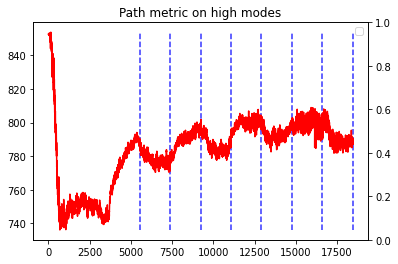

In [214]:
# Pathmectric plotting : 
# Path metric
n_batch=len(PM)/epochs
import numpy as np 
ax1 = plt.subplot()


metric = PM2

for k in epochs_adv:
    l1, = ax1.plot(2*[(k+1)*n_batch],[metric.min(),metric.max()],'--',alpha=0.8,color='blue')
    l1, = ax1.plot(2*[(k+2)*n_batch],[metric.min(),metric.max()],'--',alpha=0.8,color='blue')
    

l1 = ax1.plot(metric,color='red',label='Pathmetric')
plt.title('Path metric on high modes')

# 0 train acc, 1 test acc 
ax2 = ax1.twinx()


acc = torch.tensor([[58.8,92.08, 95.15, 96.5 , 97.3, 97.88,60],
                    [ 88.6,93.7,95.4, 95.2,95,95.7,89]])
#l2, = ax2.plot(np.array(range(7))*770+770/2,acc[1], color='orange')
plt.legend()
plt.show()

Text(0, 0.5, 'Connectivity')

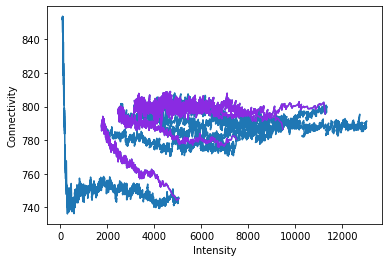

In [220]:
len_batch=len(PM)//epochs
limit = 10
plt.plot(PM[:limit*len_batch],PM2[:limit*len_batch])
for k in epochs_adv:
    if k <limit:
        plt.plot(PM[k*len_batch:(k+1)*len_batch],PM2[k*len_batch:(k+1)*len_batch],color='blueviolet')
plt.xlabel('Intensity')
plt.ylabel('Connectivity')

In [227]:
model.state_dict().keys()

odict_keys(['conv1.0.weight', 'conv2.0.weight', 'conv3.0.weight', 'out.weight'])

In [228]:
def deepcopy(model):
    m = CNN10()
    state_dict = model.state_dict()
    
    state_dict2 = m.state_dict()
    for key in model.state_dict().keys():
        state_dict2[key]=state_dict[key].clone()
    m.load_state_dict(state_dict2)
    return m 

In [261]:
X.shape

torch.Size([60000, 3, 32, 32])

Model is trained forward..........................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:18<00:00, 98.43it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  33.26050135501355  %
Test Accuracy :  47.708333333333336  %
PGD Robust Accuracy :  31.927083333333332  %
Adversarial Training starting................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.57it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  29.043021680216803  %
Test Accuracy :  52.604166666666664  %
PGD Robust Accuracy :  43.958333333333336  %
Model is trained forward..........................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 96.30it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  53.1029810298103  %
Test Accuracy :  59.791666666666664  %
PGD Robust Accuracy :  35.46875  %
Adversarial Training starting................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.60it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  28.946476964769648  %
Test Accuracy :  51.87500000000001  %
PGD Robust Accuracy :  41.979166666666664  %
Model is trained forward..........................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 96.15it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  59.08705962059621  %
Test Accuracy :  57.49999999999999  %
PGD Robust Accuracy :  32.03125  %
Adversarial Training starting................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.62it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  26.504065040650403  %
Test Accuracy :  52.1875  %
PGD Robust Accuracy :  41.041666666666664  %
Model is trained forward..........................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 95.99it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  61.949525745257446  %
Test Accuracy :  65.0  %
PGD Robust Accuracy :  36.5625  %
Adversarial Training starting................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.61it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  23.3960027100271  %
Test Accuracy :  49.0625  %
PGD Robust Accuracy :  39.166666666666664  %
Model is trained forward..........................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 95.28it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  63.72967479674797  %
Test Accuracy :  64.0625  %
PGD Robust Accuracy :  33.958333333333336  %
Adversarial Training starting................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.62it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  13.424796747967479  %
Test Accuracy :  27.604166666666668  %
PGD Robust Accuracy :  21.927083333333332  %
Model is trained forward..........................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 95.21it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  65.28455284552845  %
Test Accuracy :  64.6875  %
PGD Robust Accuracy :  33.802083333333336  %
Adversarial Training starting................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.57it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  11.90379403794038  %
Test Accuracy :  22.916666666666664  %
PGD Robust Accuracy :  19.947916666666668  %
Model is trained forward..........................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 95.71it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  66.15684281842819  %
Test Accuracy :  66.77083333333333  %
PGD Robust Accuracy :  34.375  %
Adversarial Training starting................
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [01:39<00:00, 18.53it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  10.706300813008129  %
Test Accuracy :  15.208333333333332  %
PGD Robust Accuracy :  13.854166666666668  %


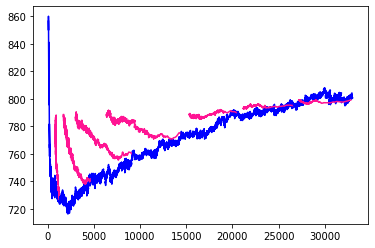

In [273]:
# Model exploration 
model = CNN10()
for epoch in range(7):
    
    print('Model is trained forward..........................')
    model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),X,y,'cnn-cifar',record=False,epochs=1,epochs_adv=[],sigmaThreshold=1.5,rate=2)
    plt.plot(PM,PM2,color='blue')
    m = deepcopy(model)
    m2 = deepcopy(model)
    print('Adversarial Training starting................')
    m,_,_,PM,PM2 = train_record_new_model(m.to(DEVICE),X,y,'cnn-cifar',record=False,epochs=1,epochs_adv=[0],sigmaThreshold=1.5,rate=2)
    plt.plot(PM,PM2,color='deeppink')
    
  
    

In [97]:
weights = [A.detach() for A in list(model.parameters())]
svr = SVR(weights)
svr.plot(sigmaThreshold=1.5)

torch.Size([32, 32, 3])


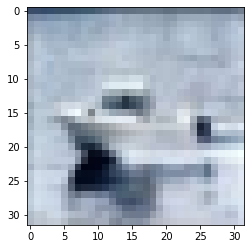

In [46]:
def printCifar(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((3,32,32)).transpose(0,2).transpose(1,0)
    print(pixels.shape)
    plt.imshow(pixels)


perm = torch.randperm(10)
def permute(x):
    return perm[x]


In [ ]:

print32x32tensor(X[2])


In [60]:
names =['airplane', 'automobile','bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def lab(output):
    return names[output.argmax()]

torch.Size([32, 32, 3])
deer
dog


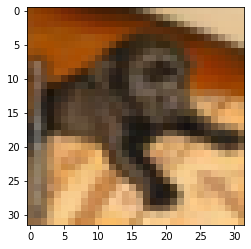

In [172]:
idx=56
printCifar(X[idx])
print(lab(model(X[idx].reshape(1,3,32,32).to(DEVICE))))
print(names[y[idx]])

In [159]:
model


CNN10(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
  )
  (out): Linear(in_features=1024, out_features=10, bias=False)
)

In [194]:
 n = 100
fmodel = PyTorchModel(model.eval(), bounds=(0, 1), preprocessing=None)
epsilons = [2]
_,clipped_atk,_ = atkFGM(fmodel, X[:n].to(DEVICE), y[:n].to(DEVICE),epsilons=epsilons)
data=clipped_atk[0]

In [195]:
print((model(data).argmax(dim=1) == model(X[:n].to(DEVICE)).argmax(dim=1) ).sum())
print((model(data).argmax(dim=1) == y[:n].to(DEVICE) ).sum())
print((model(X[:n].to(DEVICE)).argmax(dim=1) == y[:n].to(DEVICE) ).sum())

tensor(39, device='cuda:0')
tensor(8, device='cuda:0')
tensor(55, device='cuda:0')


## Similarities between models on input level 

Trying to see if there s a correlation between features learned by a model and one which was given random labels 
Correlation between features of one model 

tensor([9, 6, 2, 5, 4, 5, 9, 7, 6, 0, 6, 0, 9, 6, 0])

In [245]:

W = []
# 0 : normal 2 ep 
model = CNN10()
model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),X,y,'cnn-cifar',epochs=2,epochs_adv=[])
weights = [A.detach() for A in list(model.parameters())]
W.append(weights)
# 1 : normal 2 ep 
model = CNN10()
model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),X,y,'cnn-cifar',epochs=2,epochs_adv=[])
weights = [A.detach() for A in list(model.parameters())]
W.append(weights)
# 2 : normal 1 ep adversarial 1 ep 
model = CNN10()
model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),X,y,'cnn-cifar',epochs=2,epochs_adv=[1])
weights = [A.detach() for A in list(model.parameters())]
W.append(weights)
# Random labels
yrand = torch.randint(10,(len(y),))
model = CNN10()
model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),X,yrand,'cnn-cifar',epochs=2,epochs_adv=[])
weights = [A.detach() for A in list(model.parameters())]
W.append(weights)
# permuted labels 
model = CNN10()
model,L1,Entropy,PM,PM2= train_record_new_model(model.to(DEVICE),X,permute(y),'cnn-cifar',epochs=2,epochs_adv=[])
weights = [A.detach() for A in list(model.parameters())]
W.append(weights)

Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:19<00:00, 94.04it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  36.234756097560975  %
Test Accuracy :  48.75  %
PGD Robust Accuracy :  31.874999999999996  %


100%|███████████████████████████████████████| 1845/1845 [00:18<00:00, 98.60it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  54.32757452574526  %
Test Accuracy :  57.395833333333336  %
PGD Robust Accuracy :  34.479166666666664  %
Number of batch per epoch :  1845


100%|██████████████████████████████████████| 1845/1845 [00:18<00:00, 100.13it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  32.34756097560976  %
Test Accuracy :  49.895833333333336  %
PGD Robust Accuracy :  30.885416666666664  %


100%|██████████████████████████████████████| 1845/1845 [00:18<00:00, 100.47it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  51.355013550135496  %
Test Accuracy :  56.875  %
PGD Robust Accuracy :  32.864583333333336  %
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:18<00:00, 99.95it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  34.49017615176152  %
Test Accuracy :  52.81249999999999  %
PGD Robust Accuracy :  32.864583333333336  %


100%|███████████████████████████████████████| 1845/1845 [01:36<00:00, 19.15it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  27.210365853658537  %
Test Accuracy :  50.31250000000001  %
PGD Robust Accuracy :  40.3125  %
Number of batch per epoch :  1845


100%|███████████████████████████████████████| 1845/1845 [00:18<00:00, 99.25it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  9.876355013550135  %
Test Accuracy :  9.479166666666666  %
PGD Robust Accuracy :  4.895833333333333  %


100%|███████████████████████████████████████| 1845/1845 [00:18<00:00, 99.93it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  10.149051490514905  %
Test Accuracy :  10.104166666666666  %
PGD Robust Accuracy :  5.104166666666667  %
Number of batch per epoch :  1845


100%|██████████████████████████████████████| 1845/1845 [00:18<00:00, 100.36it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  37.0630081300813  %
Test Accuracy :  50.625  %
PGD Robust Accuracy :  32.708333333333336  %


100%|███████████████████████████████████████| 1845/1845 [00:18<00:00, 97.17it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  55.15413279132792  %
Test Accuracy :  57.49999999999999  %
PGD Robust Accuracy :  34.63541666666667  %


In [247]:
svr = []
for w in W:
    svr.append(SVR(w))

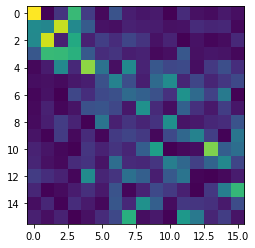

In [259]:
# Gram matrix between training methods 
v0  = svr[0].V[0]
v1  = svr[4].V[0]
plt.imshow(torch.abs(v1.T@v0))